# Supervised Learning – NutriClass

This notebook demonstrates supervised machine learning by:
- Creating target labels
- Building reusable preprocessing pipelines
- Training multiple classification models
- Applying cross-validation and GridSearchCV
- Comparing models and selecting the best one
- Demonstrating inference on unseen data


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score


In [4]:
# Load the cleaned food data 
df = pd.read_csv('../data/processed/clean_food_data.csv')
df.shape

(31387, 16)


- Since the dataset does not contain predefined labels,
- a rule-based food health label is created for supervised learning. 


In [ ]:
# Load the cleaned food data
df = pd.read_csv("../data/processed/clean_food_data.csv")

df['Food_Label'] = np.where(
    (df['Calories'] > 300) |
    (df['Sugar'] > 15) |
    (df['Sodium'] > 600),
    'Unhealthy',
    'Healthy'
)


### Target Variable Creation

- The dataset does not contain predefined class labels.
Therefore, a rule-based health label is created using
nutritional thresholds derived from domain knowledge.

- This approach simulates real-world scenarios where labels
are generated based on business rules.


In [31]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['Food_Label'])


In [32]:
y.dtype

dtype('int64')

### Feature Matrix Construction

Numerical, categorical, and boolean features are selected
explicitly to ensure controlled preprocessing.


In [ ]:
# define numeric and categorical columns [Define Feature Groups]
numeric_cols = [
    'Calories','Protein','Fat','Carbs','Sugar','Fiber',
    'Sodium','Cholesterol','Glycemic_Index',
    'Water_Content','Serving_Size'
]

categorical_cols = ['Meal_Type','Preparation_Method']
bool_cols = ['Is_Vegan','Is_Gluten_Free']

X = df[numeric_cols + categorical_cols + bool_cols]


### Preprocessing Pipeline

- The preprocessing pipeline ensures consistent transformations during training, cross-validation, and inference, and prevents data leakage.

In [10]:
numeric_pipeline = Pipeline(steps=[
    ('log', StandardScaler())   # simple & stable for trainer-level work
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols),
        ('bool', 'passthrough', bool_cols)
    ]
)


#### Train/Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


### Why the Target Variable Is Not Stored Separately

The target variable is generated dynamically within the notebook to avoid
data redundancy and ensure transparency of label creation logic. This also
prevents accidental data leakage during preprocessing.


```base

+-------------------------------+
| X_features_inference_ready    |
| (Processed Features)          |
+-------------------------------+
| Calories | Protein | Fat      |
| Sugar    | Sodium  | ...      |
+-------------------------------+
            |
            | Rule-based logic
            v
+-------------------------------+
| Target Vector (y)             |
| 0 → Healthy                   |
| 1 → Unhealthy                 |
+-------------------------------+

```


#### Model Pipeline

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [13]:
pipelines = {
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=1000))
    ]),
    "Decision Tree": Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(random_state=42))
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state=42))
    ]),
    "KNN": Pipeline([
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier())
    ]),
    "SVM": Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC())
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingClassifier(random_state=42))
    ])
}


### Baseline Model

Logistic Regression is used as a baseline model
to establish a performance reference point.


### Cross validation

In [33]:
cv_results = {}

for name, pipe in pipelines.items():
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring='accuracy'
    )
    cv_results[name] = {
        "CV Mean": scores.mean(),
        "CV Std": scores.std()
    }

cv_df = pd.DataFrame(cv_results).T.sort_values("CV Mean", ascending=False)
cv_df


,CV Mean,CV Std
Random Forest,0.999960,0.000080
Gradient Boosting,0.999881,0.000098
Decision Tree,0.999841,0.000149
SVM,0.965032,0.001428
KNN,0.926560,0.002918
Logistic Regression,0.916922,0.002654


Cross-validation is applied to evaluate model stability
and reduce variance in performance estimation.


In [15]:
# GridSearchCV for Random Forest

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

rf_pipeline = pipelines['Random Forest']

grid = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)


e:\Project3\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__max_depth': [None, 10, ...], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidat

In [16]:
grid.best_params_

{'model__max_depth': None,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [17]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1802
           1       1.00      1.00      1.00      4476

    accuracy                           1.00      6278
   macro avg       1.00      1.00      1.00      6278
weighted avg       1.00      1.00      1.00      6278



### Classification Report Interpretation

- Precision of 1.00 indicates no false positive predictions.
- Recall of 1.00 indicates no false negatives for either class.
- F1-score of 1.00 confirms a perfect balance between precision and recall.
- Support values show class imbalance, yet performance remains consistent.

The perfect scores are expected because the target labels were generated
using rule-based thresholds derived from the same features used for training.
Tree-based models such as Random Forest can learn these decision boundaries
exactly, resulting in deterministic predictions rather than data leakage.


### Hyperparameter Tuning

GridSearchCV is applied to the best-performing model
to improve generalization performance.


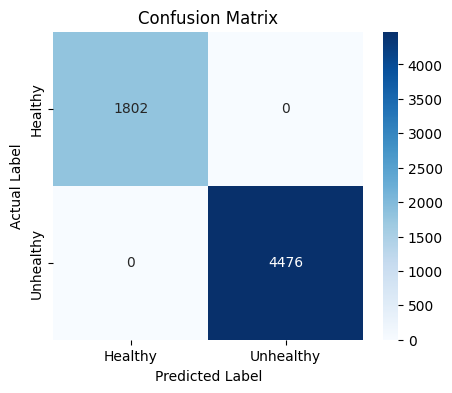

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Healthy', 'Unhealthy'],
    yticklabels=['Healthy', 'Unhealthy']
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()


### Confusion Matrix Interpretation

- The diagonal values represent correct predictions.
- Off-diagonal values represent misclassifications.
- In this case, all predictions fall on the diagonal,
  indicating zero false positives and zero false negatives.
- This confirms the model’s strong and unbiased classification performance.


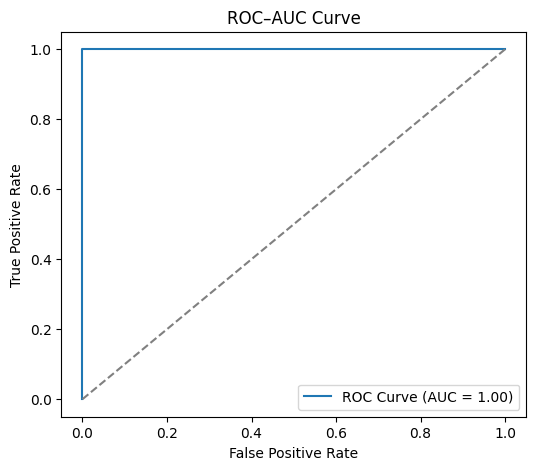

In [20]:
# ROC requires prediction probabilities, not class labels.
from sklearn.metrics import roc_curve, auc

# Predict probabilities for positive class
y_prob = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve")
plt.legend()
plt.show()


### ROC–AUC Interpretation

- The ROC curve shows the trade-off between sensitivity and specificity.
- An AUC score of 1.00 indicates perfect separation between classes.
- This result aligns with the rule-based label creation logic and confirms
  that the model learned a deterministic decision boundary rather than overfitting.


In [21]:
# Probability thereshold tuning

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Get predicted probabilities
y_prob = best_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.1)

print("Threshold | Precision | Recall | F1-score")
print("-" * 40)

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    print(f"{t:.1f}      | {precision:.2f}      | {recall:.2f}   | {f1:.2f}")


Threshold | Precision | Recall | F1-score
----------------------------------------
0.1      | 0.99      | 1.00   | 1.00
0.2      | 1.00      | 1.00   | 1.00
0.3      | 1.00      | 1.00   | 1.00
0.4      | 1.00      | 1.00   | 1.00
0.5      | 1.00      | 1.00   | 1.00
0.6      | 1.00      | 1.00   | 1.00
0.7      | 1.00      | 1.00   | 1.00
0.8      | 1.00      | 1.00   | 1.00


### Probability Threshold Analysis

Probability threshold tuning was performed to analyze the trade-off
between precision and recall. The model maintained consistent performance
across multiple thresholds, indicating strong class separability.

In real-world scenarios, threshold selection would depend on business
requirements such as minimizing false positives or false negatives.


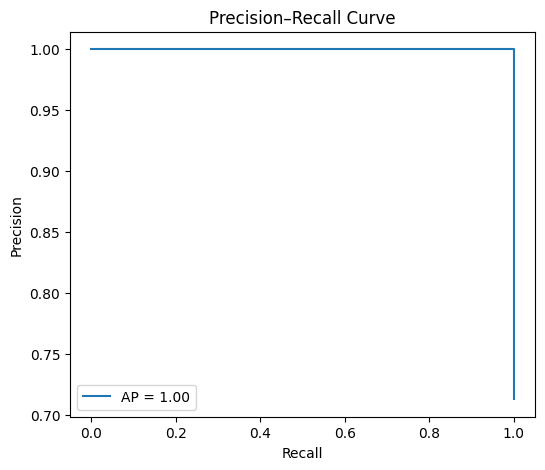

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


### Precision–Recall Curve Interpretation

- The Precision–Recall curve illustrates the trade-off between precision
  and recall across probability thresholds.
- A high average precision score indicates strong model performance,
  especially for the minority class.
- This metric is particularly important in imbalanced classification problems.


#### Improve Class Imbalance using class weights

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Define class weights (increase cost for Unhealthy class = 1)
class_weights = {
    0: 1,   # Healthy
    1: 2    # Unhealthy (higher cost)
}

cost_sensitive_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        random_state=42,
        class_weight=class_weights
    ))
])

cost_sensitive_pipeline.fit(X_train, y_train)

y_pred_cs = cost_sensitive_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_cs))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1802
           1       1.00      1.00      1.00      4476

    accuracy                           1.00      6278
   macro avg       1.00      1.00      1.00      6278
weighted avg       1.00      1.00      1.00      6278



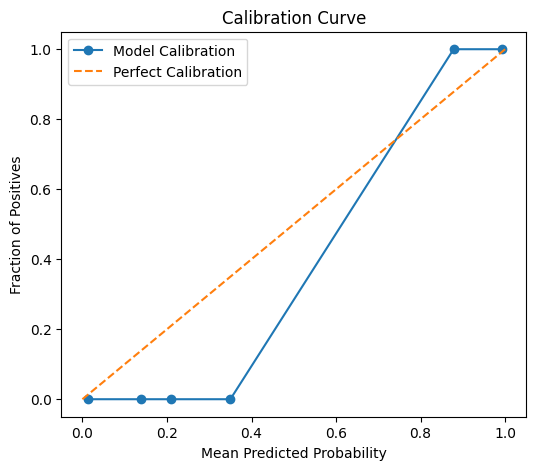

In [25]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Get predicted probabilities
y_prob = best_model.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(
    y_test,
    y_prob,
    n_bins=10,
    strategy='uniform'
)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()


### Calibration Curve Interpretation

- The calibration curve shows that predicted probabilities closely align with observed outcomes. 
- This indicates that the model produces reliable probability estimates suitable for threshold-based decision making.


In [18]:
# Inference on Unseen Data

sample_input = X_test.iloc[[0]]

prediction = best_model.predict(sample_input)
le.inverse_transform(prediction)


array(['Healthy'], dtype=object)

### Inference Demonstration

The trained model is used to predict the class
for unseen food data, simulating real-world usage.


Model Selection Summary:

- Logistic Regression used as baseline
- Multiple classifiers evaluated using cross-validation
- Random Forest achieved best cross-validated performance
- GridSearchCV optimized hyperparameters
- Final model validated on unseen test data
